# Import packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Read in data

In [53]:
athletes = pd.read_csv("athletes.csv")
athletes.head()

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


In [54]:
# Get the relevant columns only
athletes_clean = athletes.loc[:, ["gender", "age", "height", "weight", "run5k", "deadlift", "eat", "train", "background", "experience", "schedule", "howlong"]].copy()

# Clean data

In [55]:
athletes_clean.describe()

,age,height,weight,run5k,deadlift
count,331110.000000,1.598690e+05,229890.000000,3.609700e+04,1.153230e+05
mean,32.516750,1.206217e+02,170.896137,3.411464e+03,6.970503e+02
std,7.730671,2.097995e+04,58.379799,1.251980e+05,5.523235e+04
min,13.000000,0.000000e+00,1.000000,1.000000e+00,-5.000000e+02
25%,27.000000,6.600000e+01,145.000000,1.242000e+03,2.550000e+02
50%,31.000000,6.900000e+01,170.000000,1.380000e+03,3.450000e+02
75%,37.000000,7.200000e+01,192.000000,1.560000e+03,4.150000e+02
max,125.000000,8.388607e+06,20175.000000,8.388607e+06,8.388607e+06


Definitely some outliers in here. We will have to figure out what to do with those.

In [56]:
athletes.isna().sum()

athlete_id         3
name           91896
region        171744
team          267846
affiliate     181090
gender         91896
age            91896
height        263137
weight        193116
fran          367580
helen         392727
grace         382261
filthy50      403647
fgonebad      393268
run400        400760
run5k         386909
candj         318571
snatch        325726
deadlift      307683
backsq        312489
pullups       372398
eat           329074
train         317175
background    324061
experience    318070
schedule      325131
howlong       313800
dtype: int64

PLENTY of missing values here. Our dataset will be considerably smaller by the time we actually go to model.

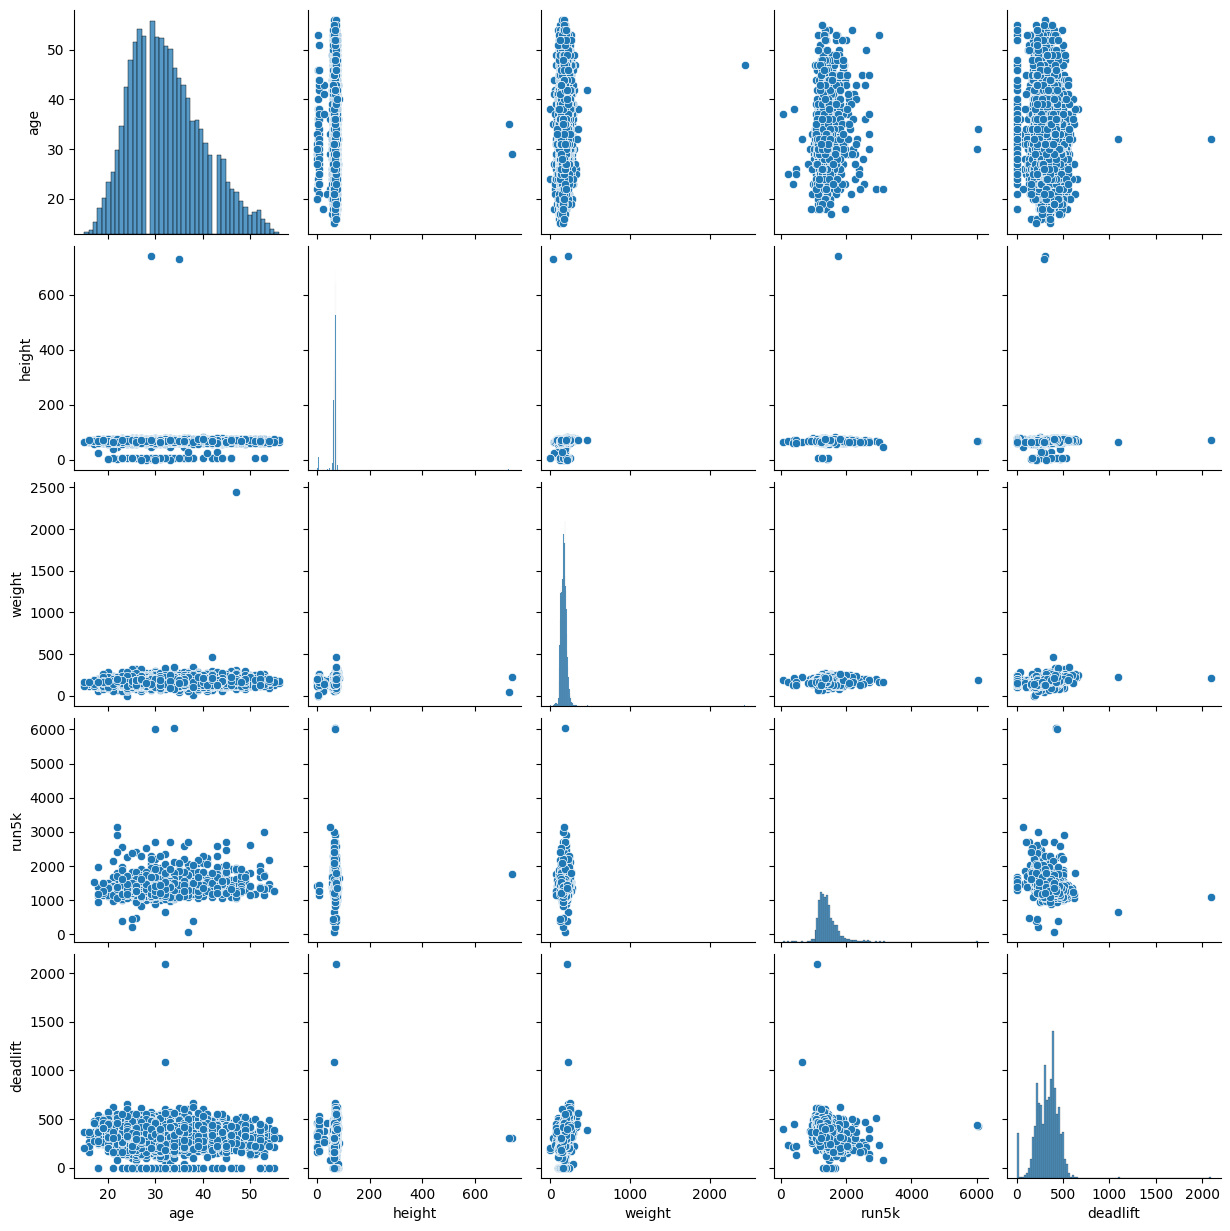

In [57]:
athletes_sampled = athletes_clean.sample(n = 12000, random_state = 31958)
sns.pairplot(athletes_sampled);

Despite some outliers and some wierd looking gaps in age, this looks pretty normally distributed and solid overall.

In [58]:
# Start by removing weird values from the above plot.
athletes_clean = athletes_clean.query('weight >= 100 and weight <= 320 and \
                                      height >= 54 and height <= 85 and \
                                      age <= 85 and \
                                      run5k >= 755 and run5k <= 2700 and \
                                      deadlift >= 45 and deadlift <= 1185')

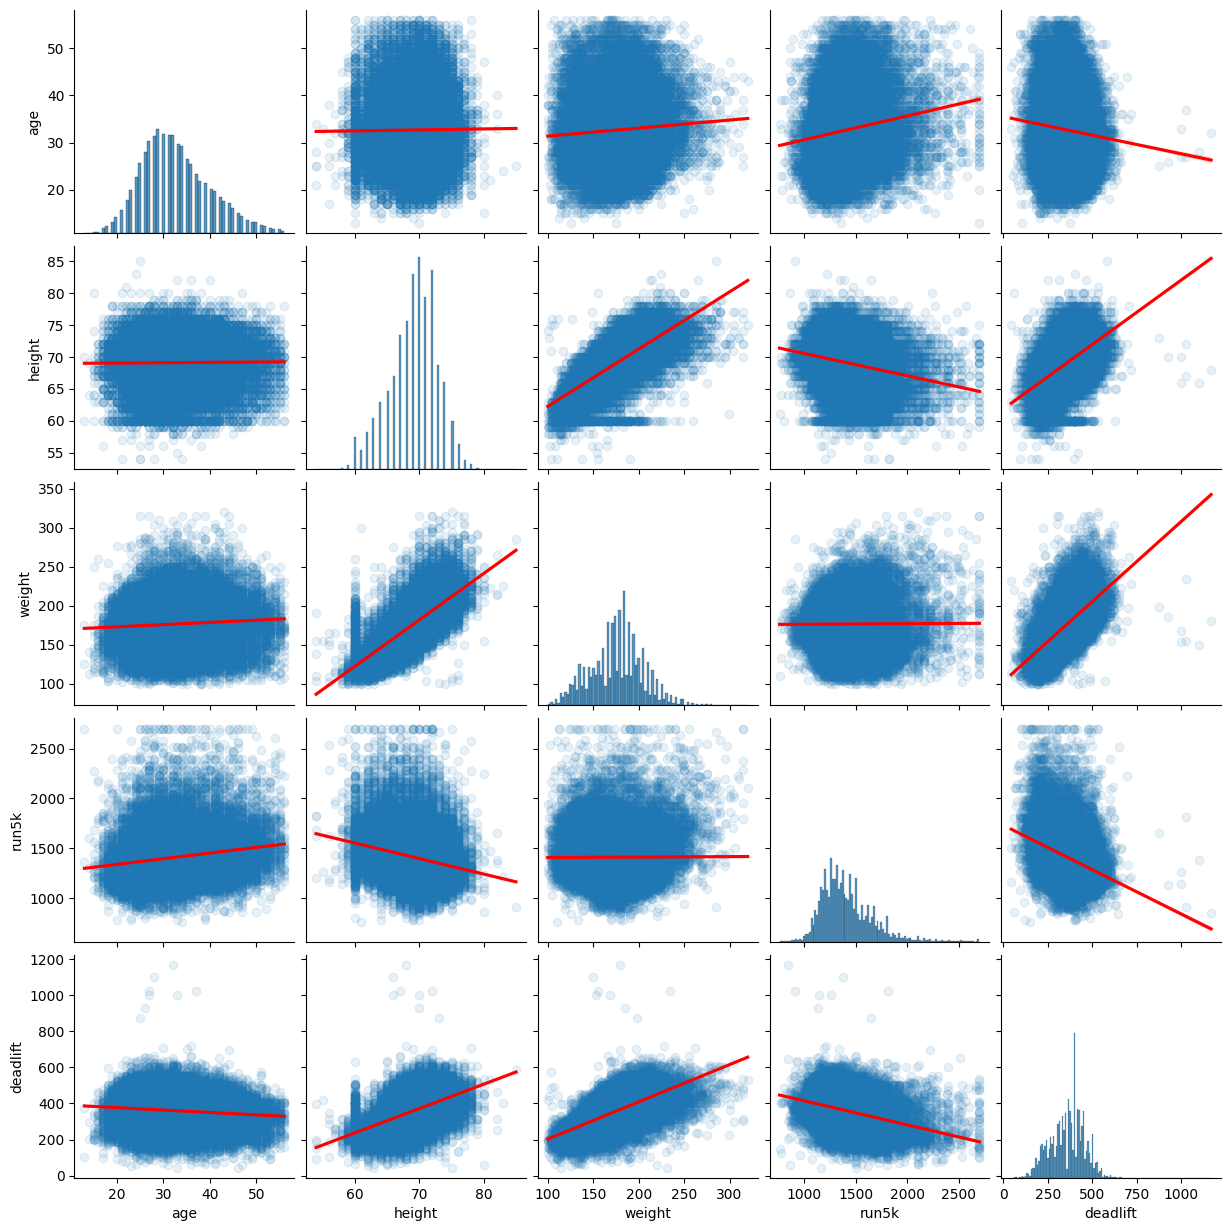

In [59]:
sns.pairplot(athletes_clean, kind = 'reg', plot_kws = {'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.1}});

Some relationships look considerably less significant now, but let's continue on to the non-numeric data.
<br>
<br>
Much of the categorical data has multiple answer selected per athlete, so we will need to find a way around this.

In [60]:
athletes_clean.head()

,gender,age,height,weight,run5k,deadlift,eat,train,background,experience,schedule,howlong
9,Male,40.0,68.0,177.0,1361.0,365.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I rec...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I typically ...,2-4 years|
12,Male,31.0,65.0,150.0,1211.0,465.0,I eat quality foods but don't measure the amou...,I workout mostly at a CrossFit Affiliate|I wri...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 3+ times a week|,2-4 years|
18,Male,30.0,70.0,155.0,1140.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN
20,Male,42.0,72.0,210.0,1412.0,515.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I wri...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,NaN,4+ years|
21,Male,30.0,71.0,200.0,1584.0,385.0,I eat whatever is convenient|,I workout mostly at a CrossFit Affiliate|I inc...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|


##### Gender

In [61]:
dummy_gender = pd.get_dummies(athletes_clean['gender']).drop('--', axis = 1)
athletes_clean = pd.concat([athletes_clean, dummy_gender], axis = 1)

##### Eating habits

In [62]:
# Drop rows with NaN in 'eat' column
athletes_clean = athletes_clean.dropna(subset = ['eat'])

# Split the values in the 'eat' column by "|" and create dummy variables
dummy_eats = pd.get_dummies(athletes_clean['eat'].str.split('|', expand = True).stack(), prefix = 'eat').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_eats = dummy_eats.drop(columns = 'eat_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_eats], axis=1)

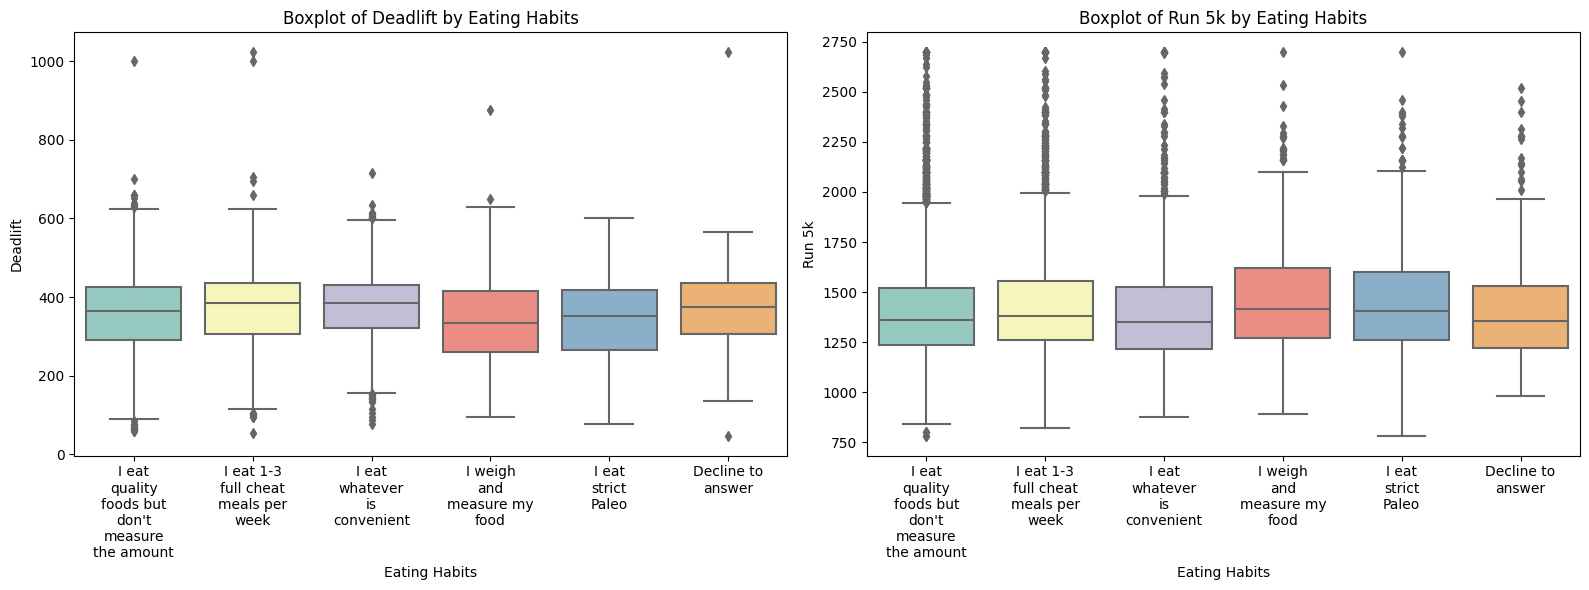

In [63]:
import textwrap

# Create a new column 'eating_habits' combining all eating habits for each athlete
athletes_clean['eating_habits'] = athletes_clean.filter(like='eat_').idxmax(axis=1).str.replace('eat_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['eating_habits'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x='eating_habits', y='deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Eating Habits')
axes[0].set_xlabel('Eating Habits')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='eating_habits', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Eating Habits')
axes[1].set_xlabel('Eating Habits')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

It doesn't look like the groups are that different, although they do overlap some anyway, which may provide some of the reason for that.

##### Training

In [64]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset=['train'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_train = pd.get_dummies(athletes_clean['train'].str.split('|', expand = True).stack(), prefix = 'train').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_train = dummy_train.drop(columns = 'train_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_train], axis=1)

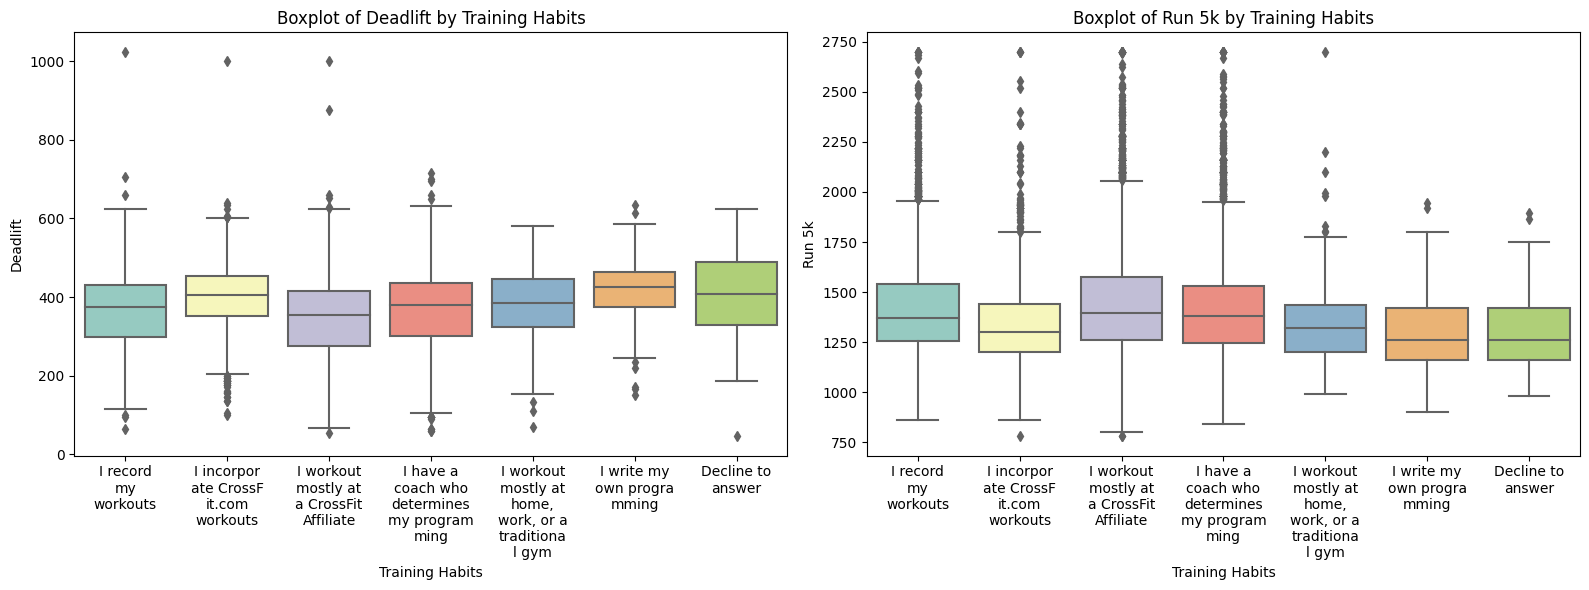

In [65]:
# Create a new column 'training_habits' combining all training habits for each athlete
athletes_clean['training_habits'] = athletes_clean.filter(like = 'train_').idxmax(axis=1).str.replace('train_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_habits'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x='training_habits', y='deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Training Habits')
axes[0].set_xlabel('Training Habits')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_habits', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Training Habits')
axes[1].set_xlabel('Training Habits')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Athletic background

In [66]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['background'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_background = pd.get_dummies(athletes_clean['background'].str.split('|', expand = True).stack(), prefix = 'background').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_background = dummy_background.drop(columns = 'background_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_background], axis = 1)

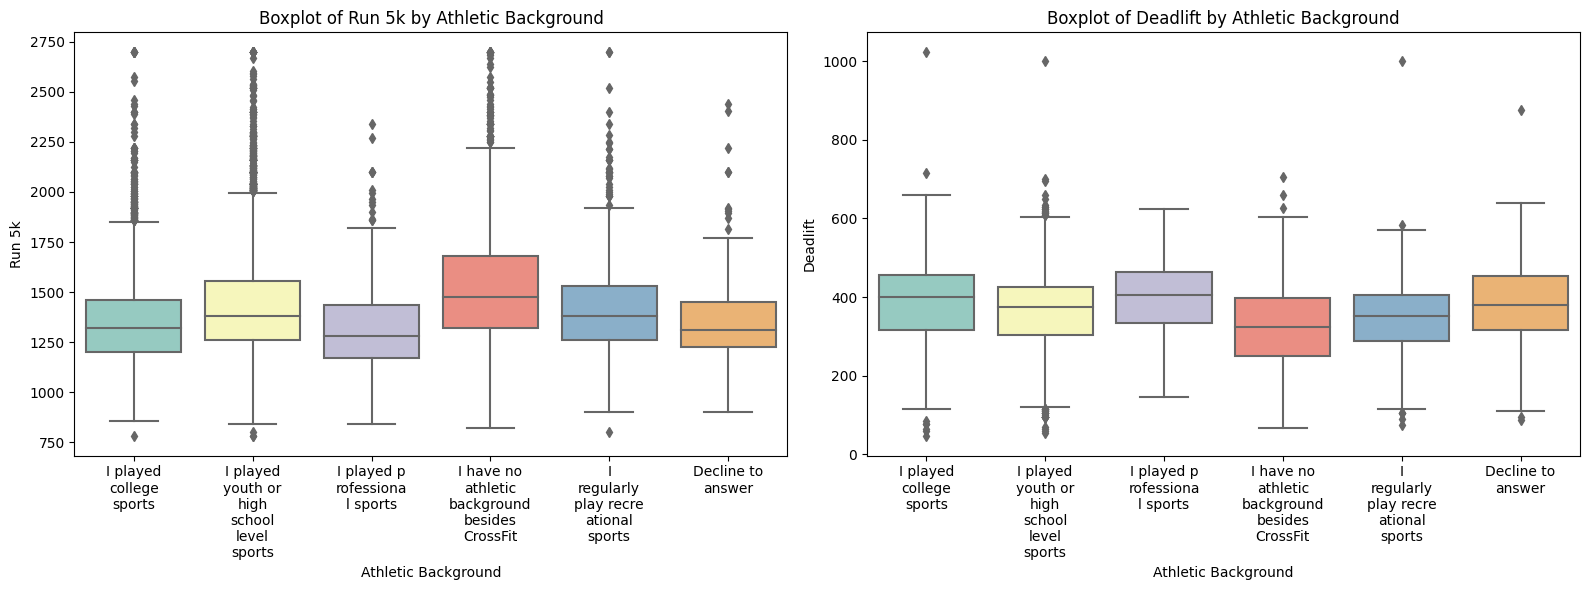

In [67]:
# Create a new column 'training_habits' combining all training habits for each athlete
athletes_clean['athletic_bg'] = athletes_clean.filter(like = 'background_').idxmax(axis=1).str.replace('background_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['athletic_bg'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[0], x='athletic_bg', y='run5k', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Run 5k by Athletic Background')
axes[0].set_xlabel('Athletic Background')
axes[0].set_ylabel('Run 5k')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[1], x='athletic_bg', y='deadlift', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Deadlift by Athletic Background')
axes[1].set_xlabel('Athletic Background')
axes[1].set_ylabel('Deadlift')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Crossfit experience

In [68]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['experience'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_experience = pd.get_dummies(athletes_clean['experience'].str.split('|', expand = True).stack(), prefix = 'experience').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_experience = dummy_experience.drop(columns = 'experience_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_experience], axis = 1)

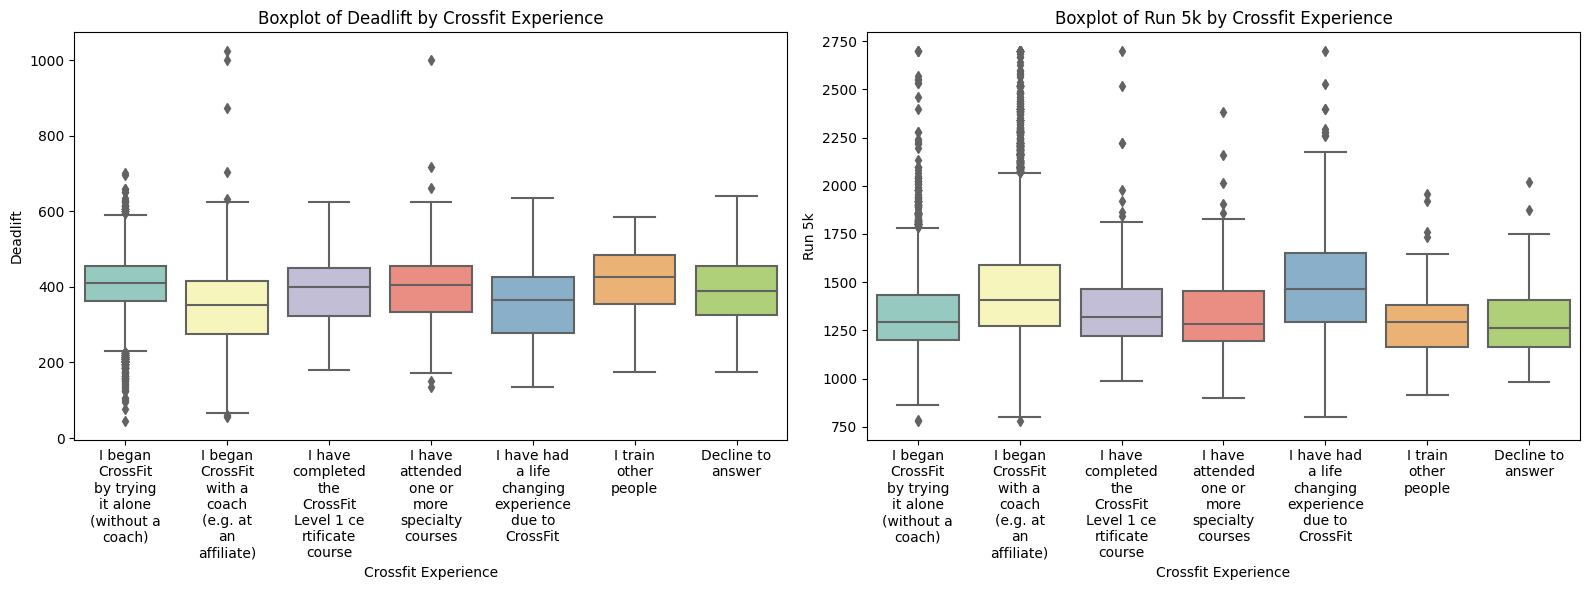

In [69]:
# Create a new column 'crossfit_experience' combining all training habits for each athlete
athletes_clean['crossfit_experience'] = athletes_clean.filter(like = 'experience_').idxmax(axis=1).str.replace('experience_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['crossfit_experience'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x = 'crossfit_experience', y = 'deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Crossfit Experience')
axes[0].set_xlabel('Crossfit Experience')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='crossfit_experience', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Crossfit Experience')
axes[1].set_xlabel('Crossfit Experience')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Training schedule

In [70]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['schedule'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_schedule = pd.get_dummies(athletes_clean['schedule'].str.split('|', expand = True).stack(), prefix = 'schedule').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_schedule = dummy_schedule.drop(columns = 'schedule_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_schedule], axis = 1)

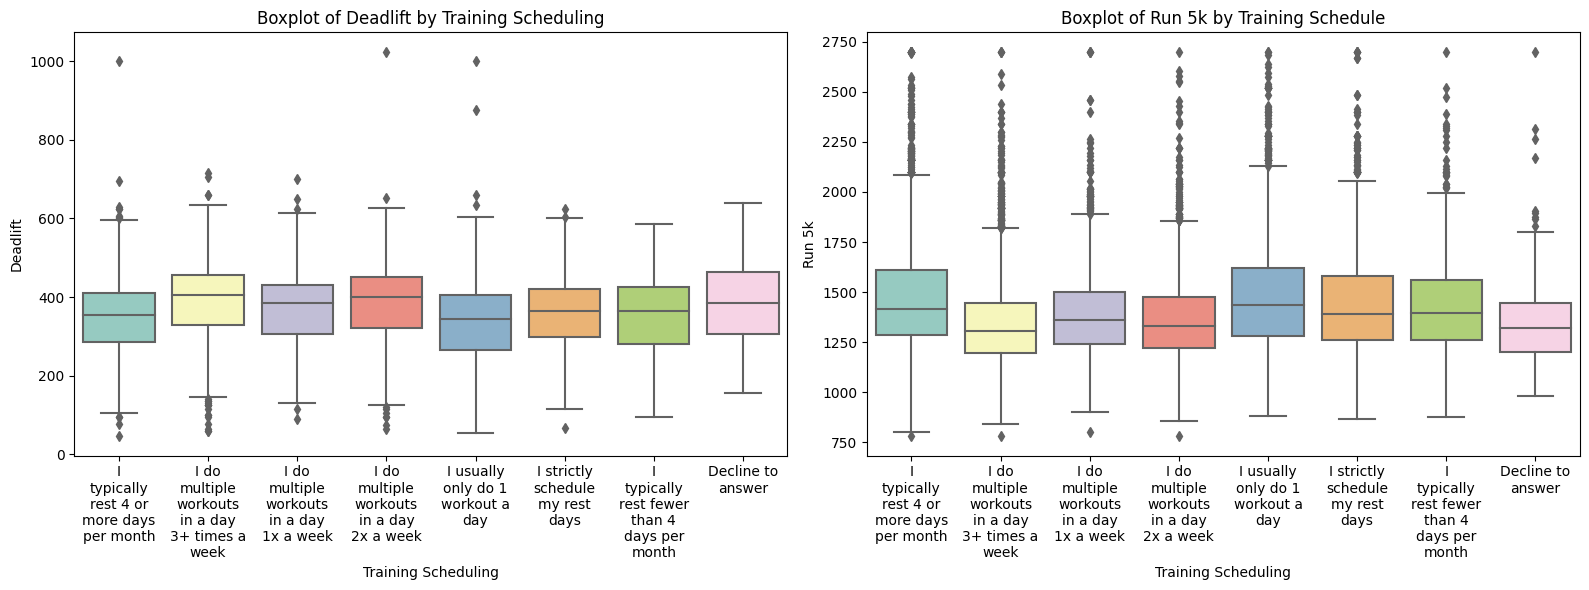

In [71]:
# Create a new column 'training_schedule' combining all training schedules for each athlete
athletes_clean['training_schedule'] = athletes_clean.filter(like = 'schedule_').idxmax(axis=1).str.replace('schedule_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_schedule'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax = axes[0], x = 'training_schedule', y = 'deadlift', data = athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Training Scheduling')
axes[0].set_xlabel('Training Scheduling')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_schedule', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Training Schedule')
axes[1].set_xlabel('Training Scheduling')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### How long have they been training

In [72]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['howlong'])

def find_longest_training(row):
    if pd.isna(row):
        return np.nan

    weights = {'Less than 6 months': 1, '6-12 months': 2, '1-2 years': 3, '2-4 years': 4, '4+ years': 5}

    categories = row.split('|')
    return max(categories, key = lambda x: weights.get(x, 0))

# Create a new column 'howlong_group' based on the longest category
athletes_clean['howlong_group'] = athletes_clean['howlong'].apply(find_longest_training)

# Split the values in the 'train' column by "|" and create dummy variables
dummy_howlong = pd.get_dummies(athletes_clean['howlong_group'].str.split('|', expand = True).stack(), prefix = 'howlong').groupby(level = 0).sum()

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_howlong], axis = 1)

<ipython-input-72-e235ea598182>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  athletes_clean['howlong_group'] = athletes_clean['howlong'].apply(find_longest_training)


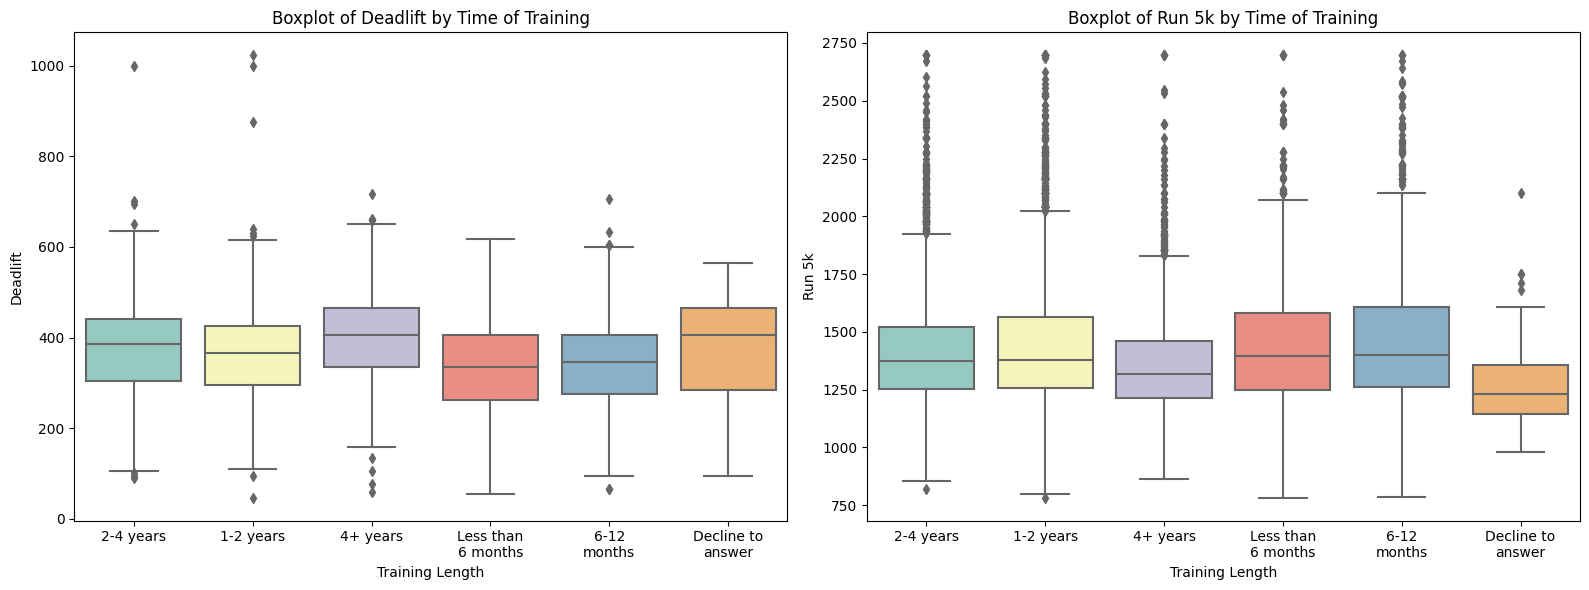

In [73]:
# Create a new column 'training_schedule' combining all training schedules for each athlete
athletes_clean['training_length'] = athletes_clean.filter(like = 'howlong_').drop('howlong_group', axis = 1).idxmax(axis=1).str.replace('howlong_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_length'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax = axes[0], x = 'training_length', y = 'deadlift', data = athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Time of Training')
axes[0].set_xlabel('Training Length')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_length', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Time of Training')
axes[1].set_xlabel('Training Length')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

# Model

#### Deadlift

In [74]:
athletes_clean['age_squared'] = athletes_clean['age']**2
#deadlift_nuts = athletes_clean.sample(n = 2000)
deadlift_nuts = athletes_clean
# Make predictors for model
deadlift_x = deadlift_nuts.loc[:, ['age', 'age_squared', 'height', 'weight', 'Female', 'Male', 'eat_Decline to answer', 'eat_I eat 1-3 full cheat meals per week',
                                    "eat_I eat quality foods but don't measure the amount", 'eat_I eat strict Paleo', 'eat_I eat whatever is convenient',
                                    'eat_I weigh and measure my food', 'train_Decline to answer', 'train_I have a coach who determines my programming',
                                    'train_I incorporate CrossFit.com workouts', 'train_I record my workouts', 'train_I workout mostly at a CrossFit Affiliate',
                                    'train_I workout mostly at home, work, or a traditional gym', 'train_I write my own programming',
                                    'background_Decline to answer', 'background_I have no athletic background besides CrossFit', 'background_I played college sports',
                                    'background_I played professional sports', 'background_I played youth or high school level sports',
                                    'background_I regularly play recreational sports', 'experience_I began CrossFit by trying it alone (without a coach)',
                                    'experience_I began CrossFit with a coach (e.g. at an affiliate)', 'experience_I have attended one or more specialty courses',
                                    'experience_I have completed the CrossFit Level 1 certificate course', 'experience_I have had a life changing experience due to CrossFit',
                                    'experience_I train other people', 'schedule_Decline to answer',
                                    'schedule_I do multiple workouts in a day 1x a week',
                                    'schedule_I do multiple workouts in a day 2x a week',
                                    'schedule_I do multiple workouts in a day 3+ times a week',
                                    'schedule_I strictly schedule my rest days',
                                    'schedule_I typically rest 4 or more days per month',
                                    'schedule_I typically rest fewer than 4 days per month',
                                    'schedule_I usually only do 1 workout a day',
                                    'howlong_1-2 years',
                                    'howlong_2-4 years', 'howlong_4+ years', 'howlong_6-12 months',
                                    'howlong_Decline to answer', 'howlong_Less than 6 months']].apply(pd.to_numeric, errors='coerce')

# Make response variable for model
deadlift_y = deadlift_nuts.deadlift.to_numpy()

In [37]:
k = deadlift_x.shape[1]

with pm.Model() as deadlift_model:
    # Priors for coefficients
    beta = pm.Normal('beta', mu = 0, sigma = 10, shape = k)
    sigma = pm.HalfNormal('sigma', sigma = 10)

    # Intercept
    alpha = pm.Normal('alpha', mu = 0, sigma = 10)

    # Linear regression model
    mu = pm.Deterministic('mu', alpha + pm.math.dot(deadlift_x, beta))

    # Likelihood
    y = pm.Normal('y', mu = mu, sigma = sigma, observed = deadlift_y)

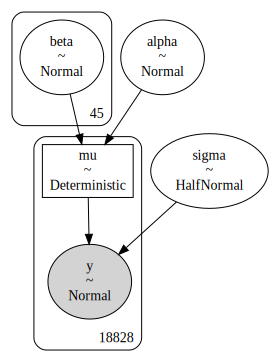

In [38]:
# Graphical representation
pm.model_to_graphviz(deadlift_model)

In [39]:
with deadlift_model:
    trace = pm.sample(2000, tune = 1000, random_seed = 31958)
    deadlift_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (46), generating only 20 plots
  warnings.warn(


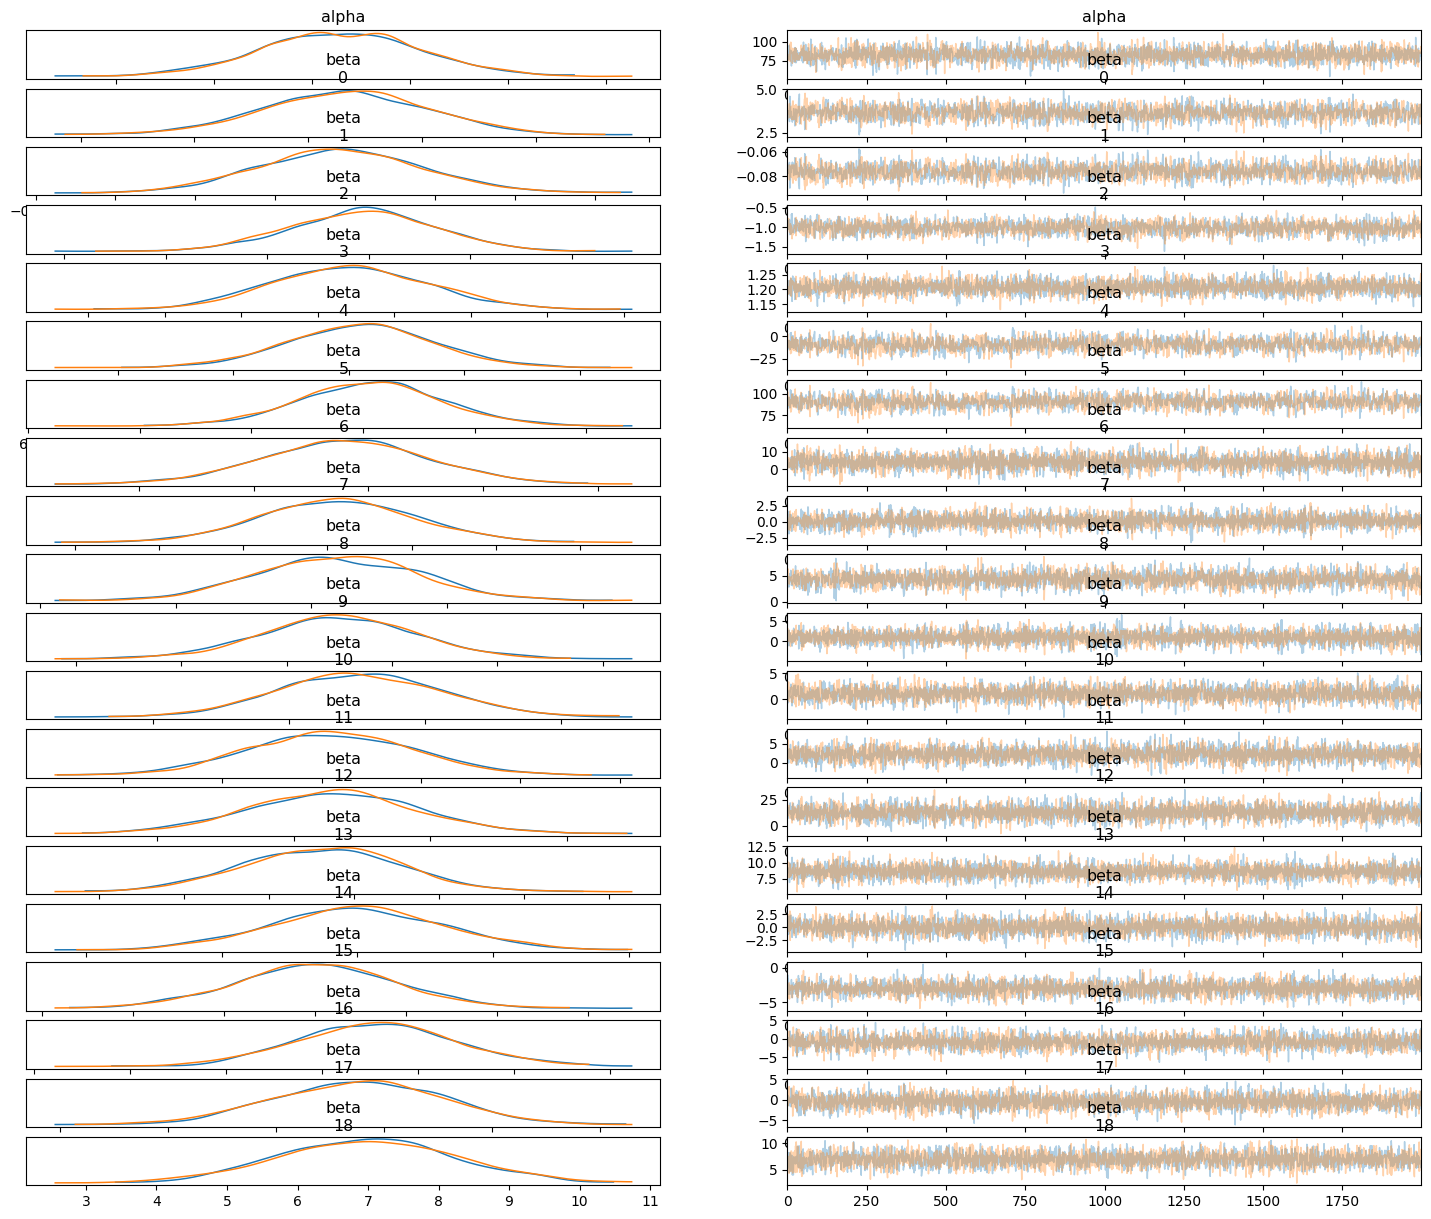

In [40]:
az.plot_trace(deadlift_trace, compact = False, var_names = ['alpha', 'beta'], figsize = (18, 15));

In [41]:
az.summary(deadlift_trace, var_names = ['alpha', 'beta'])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,82.836,8.236,67.635,98.910,0.148,0.105,3093.0,2811.0,1.0
beta[0],3.660,0.363,2.963,4.322,0.008,0.006,2104.0,2493.0,1.0
beta[1],-0.076,0.005,-0.086,-0.066,0.000,0.000,2112.0,2383.0,1.0
beta[2],-1.012,0.140,-1.279,-0.758,0.003,0.002,2809.0,3222.0,1.0
beta[3],1.208,0.020,1.171,1.247,0.000,0.000,4125.0,3312.0,1.0
beta[4],-9.014,6.318,-20.998,2.816,0.146,0.104,1863.0,2456.0,1.0
beta[5],90.632,6.413,78.411,102.691,0.147,0.104,1895.0,2468.0,1.0
beta[6],3.964,3.625,-2.607,11.006,0.051,0.046,5042.0,2935.0,1.0
beta[7],0.120,0.924,-1.525,1.921,0.013,0.017,5236.0,2879.0,1.0
beta[8],4.388,1.195,2.133,6.551,0.022,0.015,3081.0,3288.0,1.0


The rhats and the trace plots show a well-converged model!

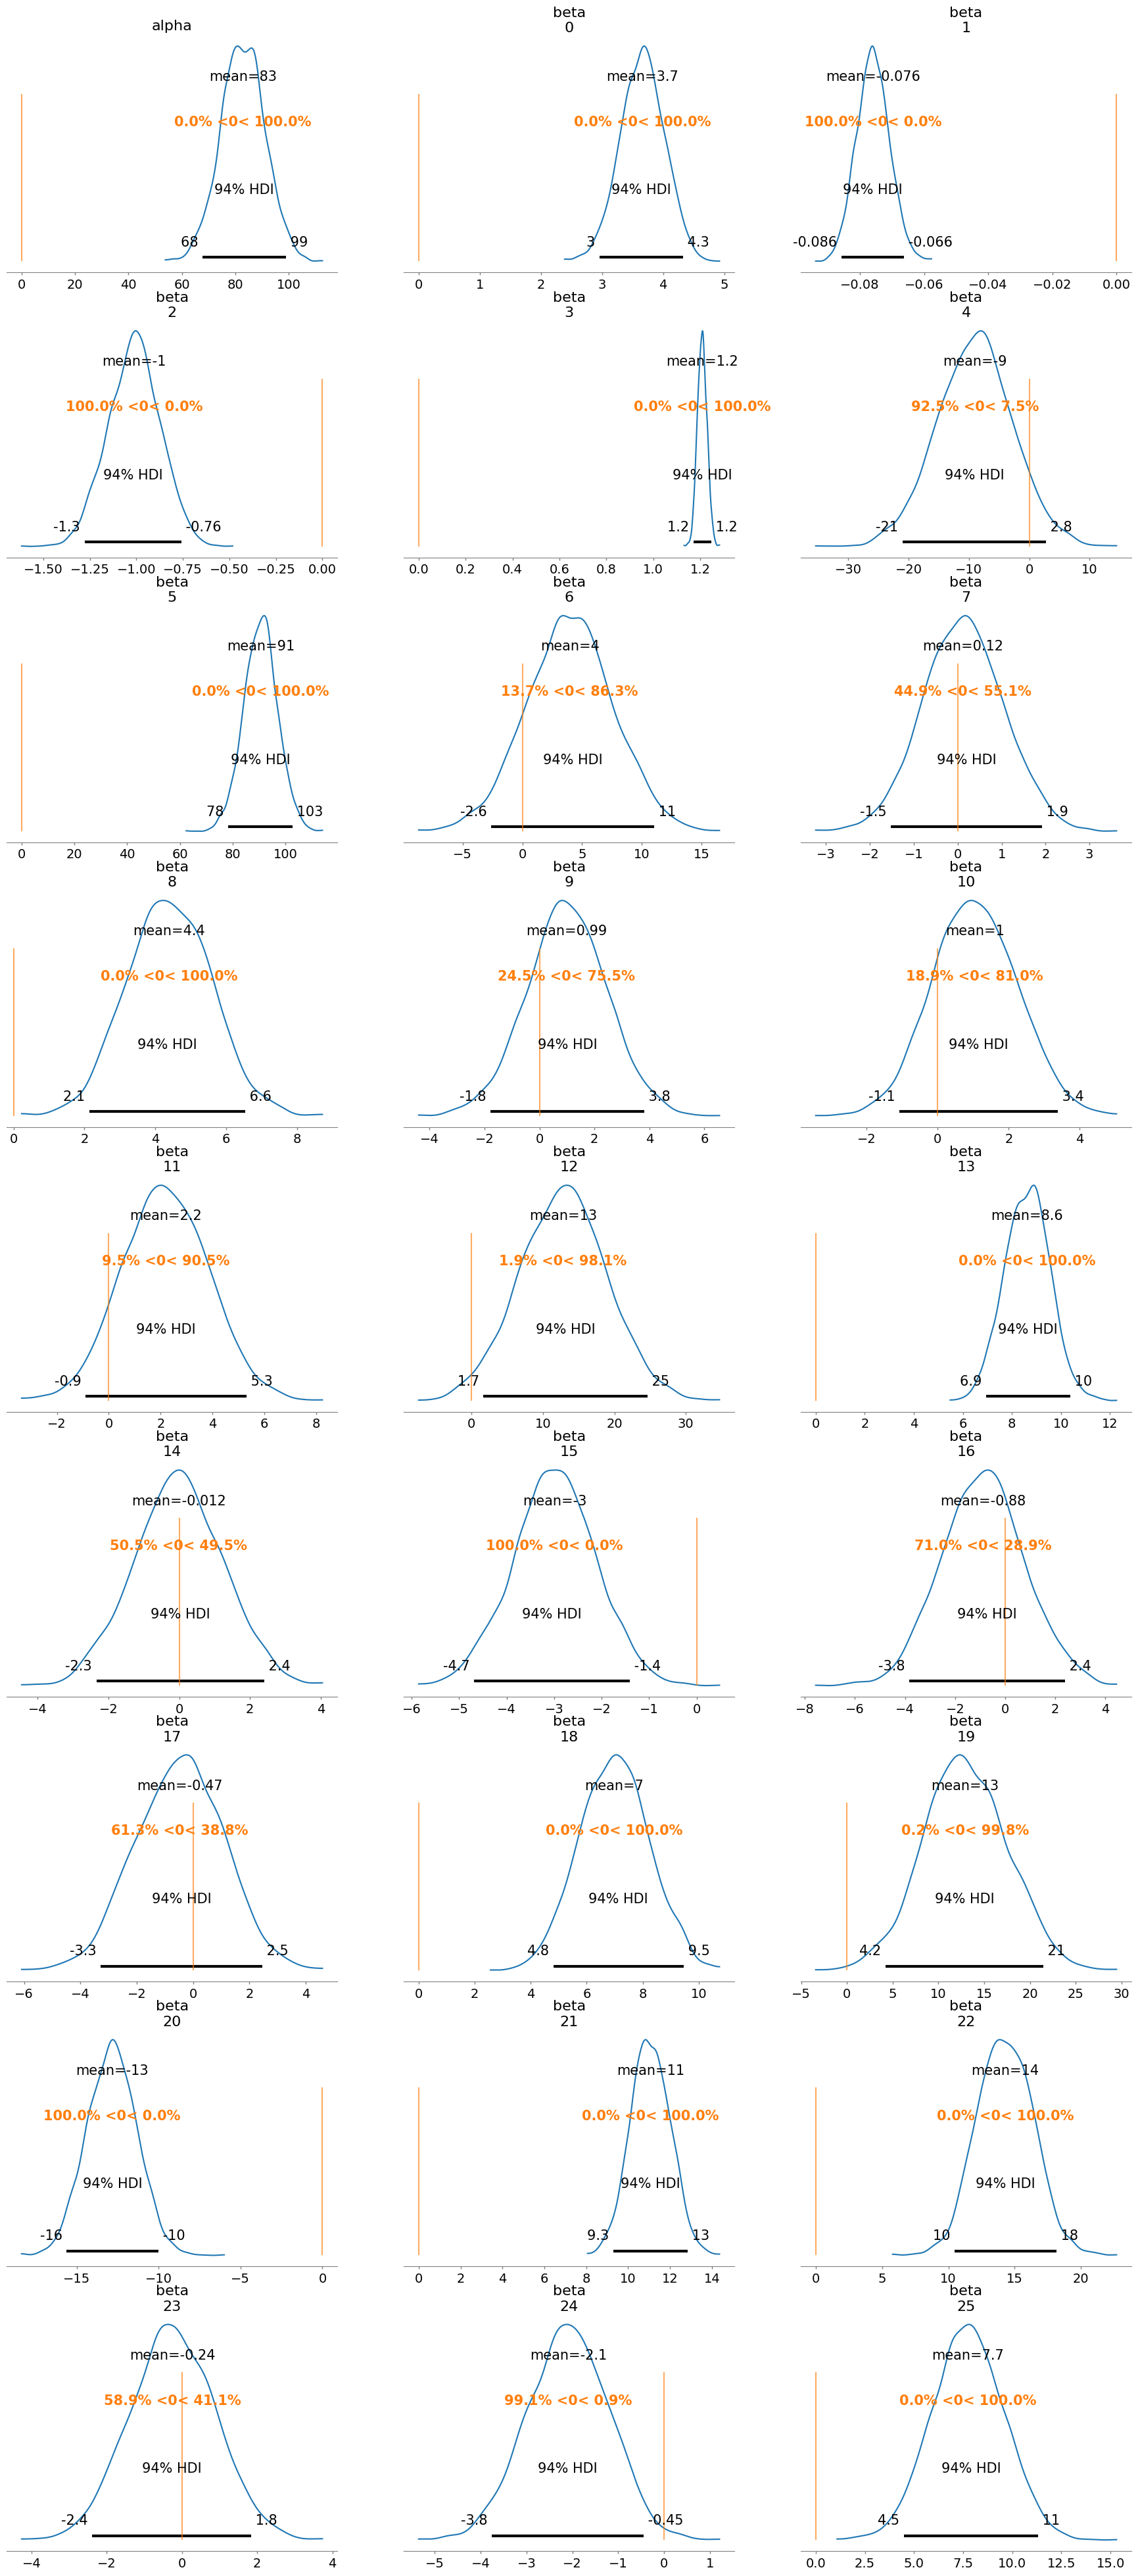

In [42]:
az.plot_posterior(
    deadlift_trace,
    var_names=['alpha', 'beta'],
    ref_val=0,
    coords={'beta_dim_0': slice(0, 25)}
);

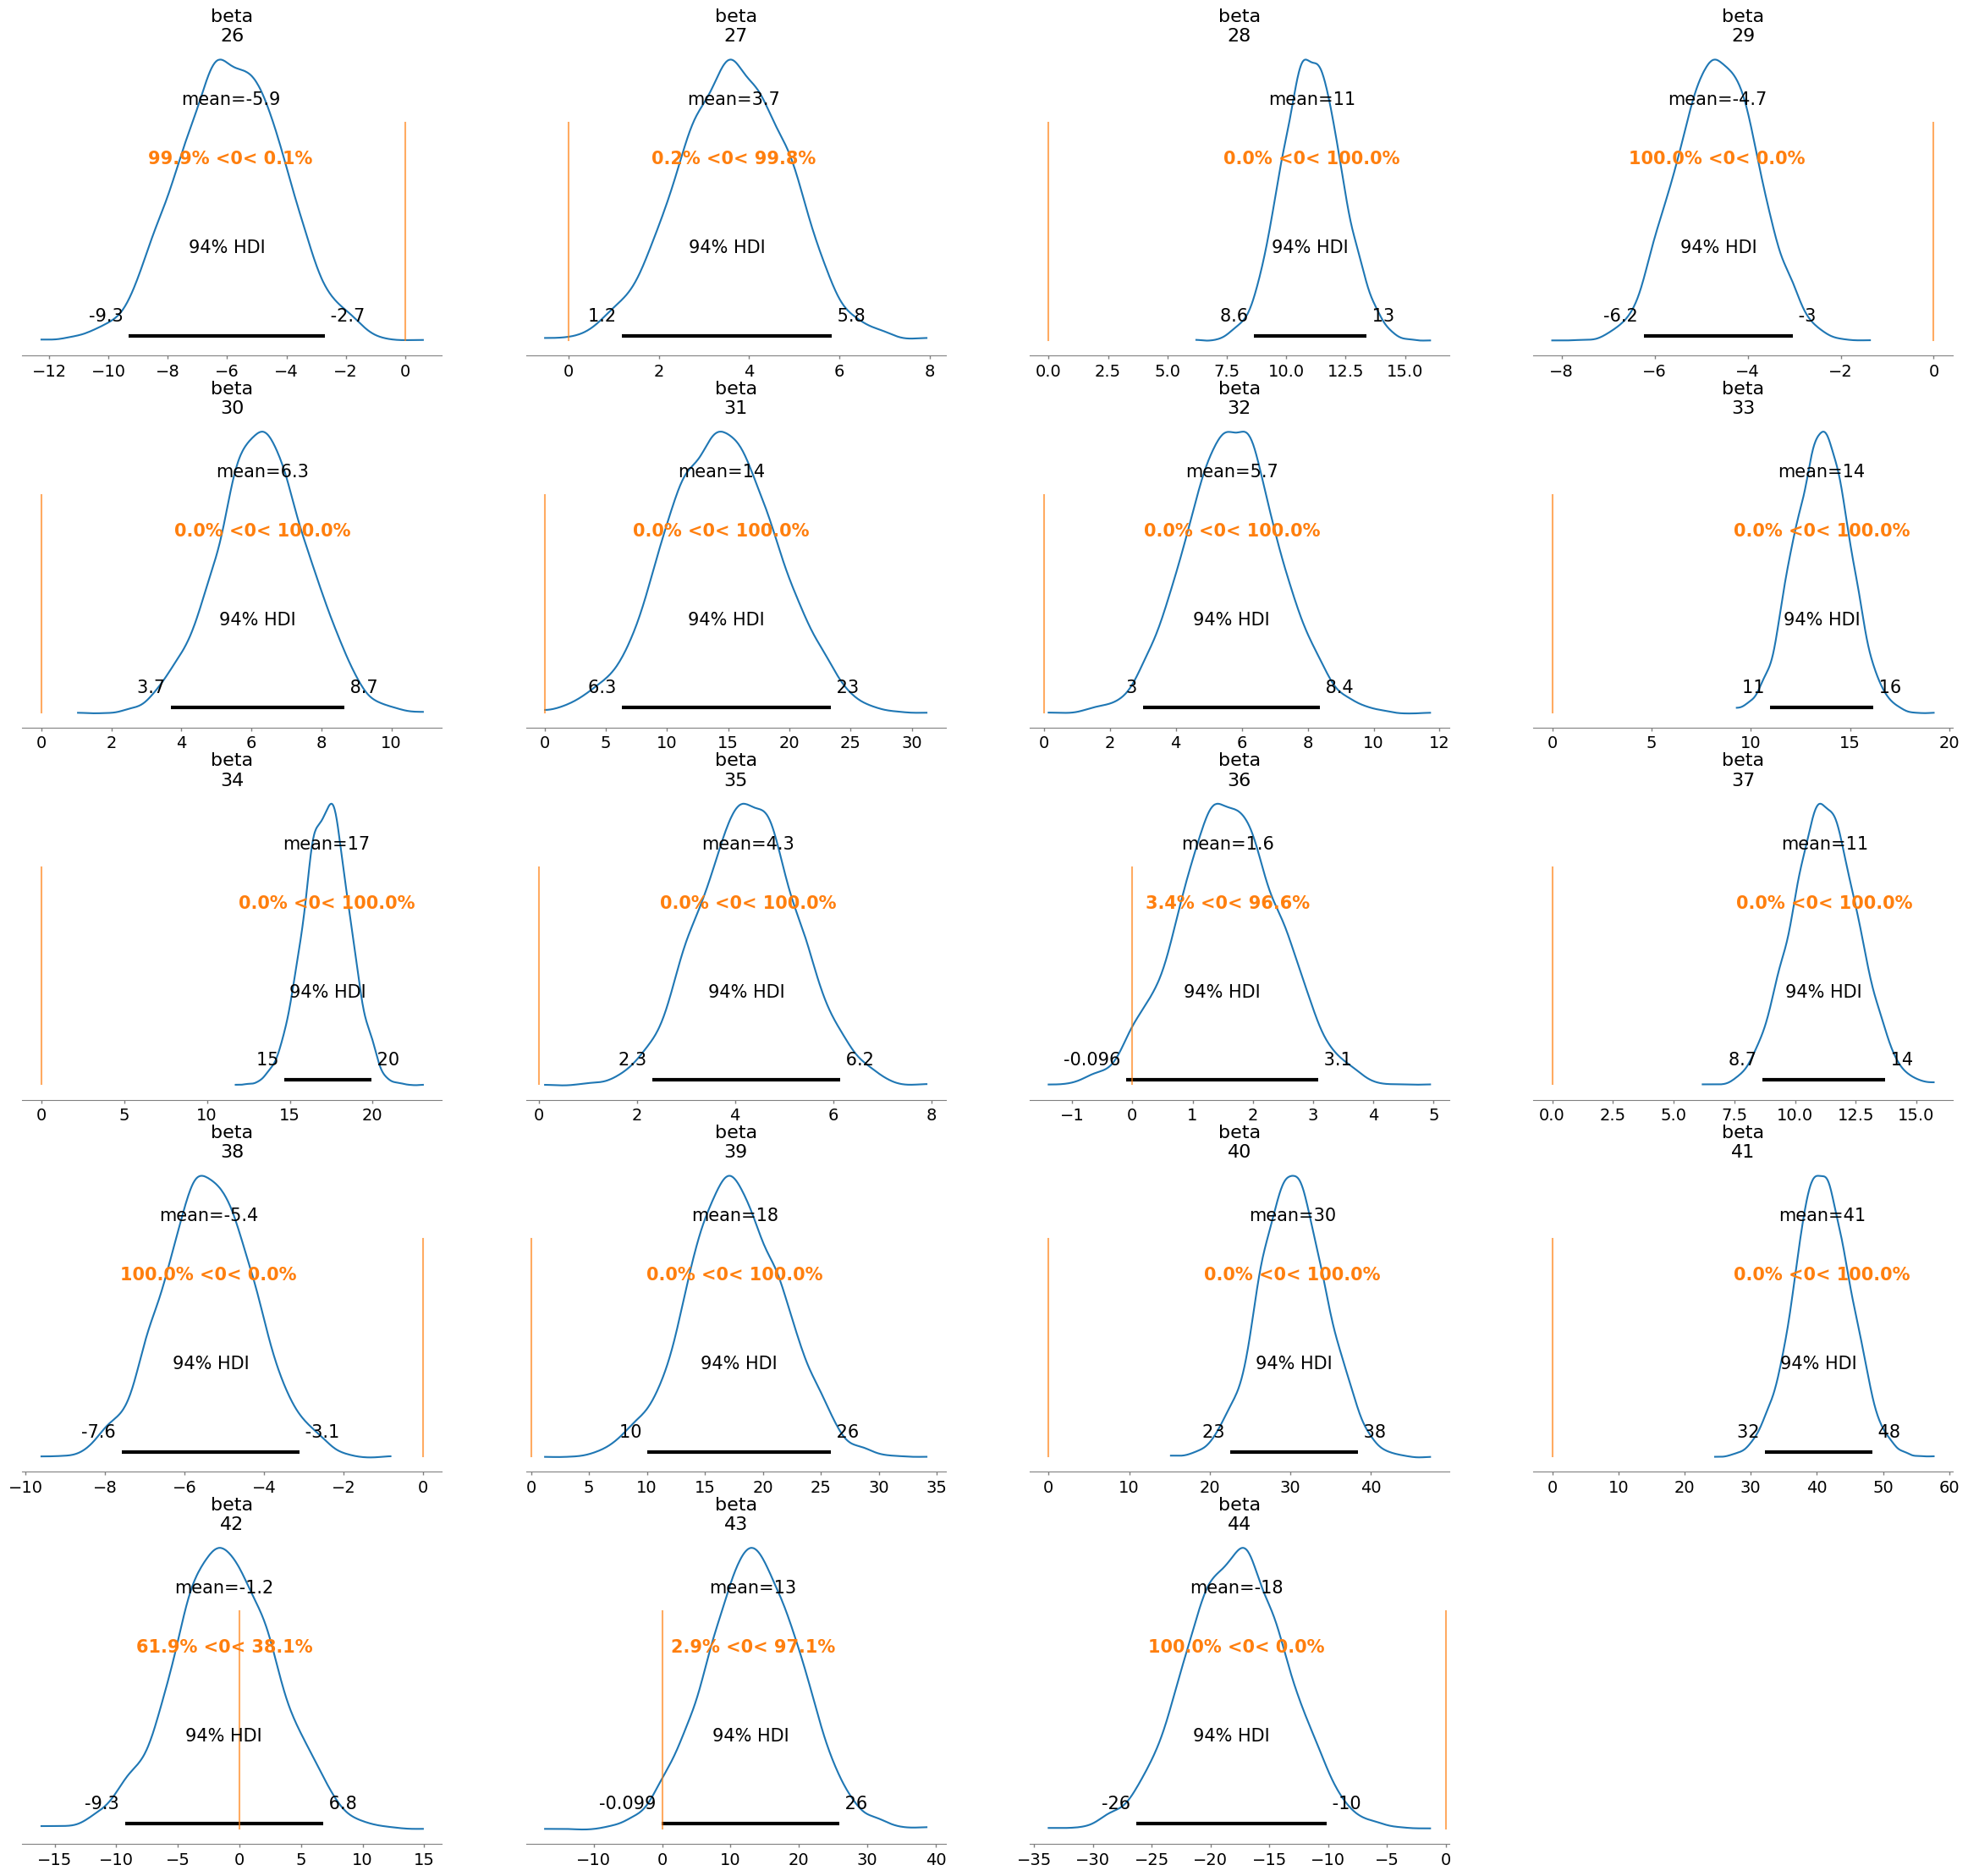

In [43]:
az.plot_posterior(
    deadlift_trace,
    var_names = ['beta'],
    ref_val = 0,
    coords = {'beta_dim_0': slice(26, 45)}
);

<Axes: title={'center': 'y / y'}>

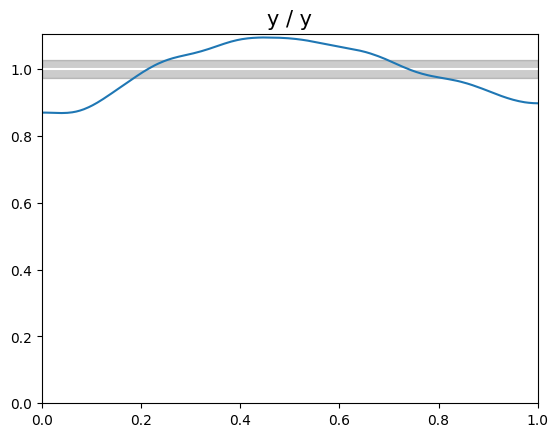

In [44]:
deadlift_pp = pm.sample_posterior_predictive(
    deadlift_trace,
    model = deadlift_model
)

az.plot_bpv(deadlift_pp)

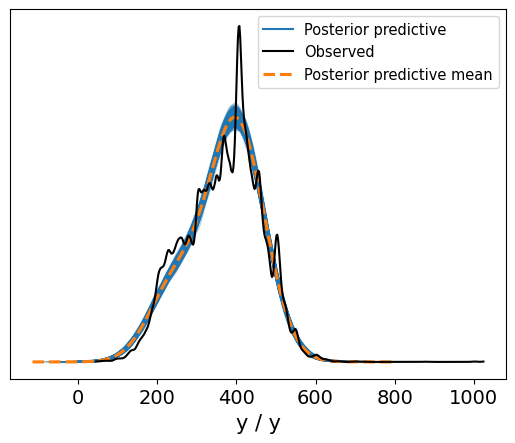

In [45]:
az.plot_ppc(deadlift_pp);

#### 5k Time

In [75]:
# import pandas as pd

# # Create a sample DataFrame
# data = {'Height': [165, 170, 155, 180],
#         'Weight': [60, 75, 50, 85]}

# df = pd.DataFrame(data)

# Function to calculate BMI
def calculate_bmi(height, weight):
    bmi = 703 * weight / (height ** 2)
    return bmi

# Apply the function to create a new 'BMI' column
athletes_clean['BMI'] = athletes_clean.apply(lambda row: calculate_bmi(row['height'], row['weight']), axis=1)

# Display the DataFrame with the new 'BMI' column
athletes_clean.head()


,gender,age,height,weight,run5k,deadlift,eat,train,background,experience,...,howlong_group,howlong_1-2 years,howlong_2-4 years,howlong_4+ years,howlong_6-12 months,howlong_Decline to answer,howlong_Less than 6 months,training_length,age_squared,BMI
9,Male,40.0,68.0,177.0,1361.0,365.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I rec...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,...,2-4 years,0,1,0,0,0,0,2-4 years,1600.0,26.909818
12,Male,31.0,65.0,150.0,1211.0,465.0,I eat quality foods but don't measure the amou...,I workout mostly at a CrossFit Affiliate|I wri...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,...,2-4 years,0,1,0,0,0,0,2-4 years,961.0,24.958580
21,Male,30.0,71.0,200.0,1584.0,385.0,I eat whatever is convenient|,I workout mostly at a CrossFit Affiliate|I inc...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,...,1-2 years,1,0,0,0,0,0,1-2 years,900.0,27.891291
25,Male,39.0,66.0,158.0,1363.0,385.0,I eat strict Paleo|I eat quality foods but don...,I workout mostly at a CrossFit Affiliate|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,...,1-2 years,1,0,0,0,0,0,1-2 years,1521.0,25.499082
42,Male,44.0,72.0,214.0,1225.0,551.0,I eat strict Paleo|I eat 1-3 full cheat meals ...,"I workout mostly at home, work, or a tradition...",I played professional sports|,I began CrossFit by trying it alone (without a...,...,1-2 years,1,0,0,0,0,0,1-2 years,1936.0,29.020448


In [76]:
#run_nuts = athletes_clean.sample(n = 2000)
run_nuts = athletes_clean
# Make predictors for model
run_x = run_nuts.loc[:, ['age', 'age_squared', 'BMI', 'Female', 'Male', 'eat_Decline to answer', 'eat_I eat 1-3 full cheat meals per week',
                              "eat_I eat quality foods but don't measure the amount", 'eat_I eat strict Paleo', 'eat_I eat whatever is convenient',
                              'eat_I weigh and measure my food', 'train_Decline to answer', 'train_I have a coach who determines my programming',
                              'train_I incorporate CrossFit.com workouts', 'train_I record my workouts', 'train_I workout mostly at a CrossFit Affiliate',
                              'train_I workout mostly at home, work, or a traditional gym', 'train_I write my own programming',
                              'background_Decline to answer', 'background_I have no athletic background besides CrossFit', 'background_I played college sports',
                              'background_I played professional sports', 'background_I played youth or high school level sports',
                              'background_I regularly play recreational sports', 'experience_I began CrossFit by trying it alone (without a coach)',
                              'experience_I began CrossFit with a coach (e.g. at an affiliate)', 'experience_I have attended one or more specialty courses',
                              'experience_I have completed the CrossFit Level 1 certificate course', 'experience_I have had a life changing experience due to CrossFit',
                              'experience_I train other people', 'schedule_Decline to answer',
                              'schedule_I do multiple workouts in a day 1x a week',
                              'schedule_I do multiple workouts in a day 2x a week',
                              'schedule_I do multiple workouts in a day 3+ times a week',
                              'schedule_I strictly schedule my rest days',
                              'schedule_I typically rest 4 or more days per month',
                              'schedule_I typically rest fewer than 4 days per month',
                              'schedule_I usually only do 1 workout a day',
                              'howlong_1-2 years',
                              'howlong_2-4 years', 'howlong_4+ years', 'howlong_6-12 months',
                              'howlong_Decline to answer', 'howlong_Less than 6 months']].apply(pd.to_numeric, errors='coerce')

# Make response variable for model
run_y = run_nuts.run5k.to_numpy()

In [77]:
run_x.head()

,age,age_squared,BMI,Female,Male,eat_Decline to answer,eat_I eat 1-3 full cheat meals per week,eat_I eat quality foods but don't measure the amount,eat_I eat strict Paleo,eat_I eat whatever is convenient,...,schedule_I strictly schedule my rest days,schedule_I typically rest 4 or more days per month,schedule_I typically rest fewer than 4 days per month,schedule_I usually only do 1 workout a day,howlong_1-2 years,howlong_2-4 years,howlong_4+ years,howlong_6-12 months,howlong_Decline to answer,howlong_Less than 6 months
9,40.0,1600.0,26.909818,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,0,0,0
12,31.0,961.0,24.958580,0,1,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
21,30.0,900.0,27.891291,0,1,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
25,39.0,1521.0,25.499082,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
42,44.0,1936.0,29.020448,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [78]:
k = run_x.shape[1]

with pm.Model() as run_model:
    # Priors for coefficients
    beta = pm.Normal('beta', mu = 0, sigma = 100, shape = k)
    sigma = pm.HalfNormal('sigma', sigma = 100)

    # Intercept
    alpha = pm.Normal('alpha', mu = 0, sigma = 50)

    # Linear regression model
    mu = pm.Deterministic('mu', alpha + pm.math.dot(run_x, beta))

    # Likelihood
    y = pm.SkewNormal('y', alpha = 5, mu = mu, sigma = sigma, observed = run_y)

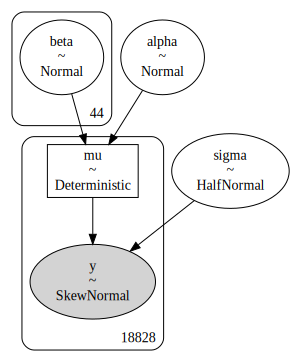

In [79]:
# Graphical representation
pm.model_to_graphviz(run_model)

In [ ]:
with run_model:
    trace = pm.sample(2000, tune = 1000, random_seed = 31958)
    run_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

In [ ]:
az.plot_trace(run_trace, compact = False, var_names = ['alpha', 'beta'], figsize = (18, 15));

In [ ]:
az.summary(run_trace, var_names = ['alpha', 'beta'])

In [ ]:
az.plot_posterior(
    run_trace,
    var_names=['alpha', 'beta'],
    ref_val=0,
    coords={'beta_dim_0': slice(0, 25)}
);

In [ ]:
az.plot_posterior(
    run_trace,
    var_names=['alpha', 'beta'],
    ref_val=0,
    coords={'beta_dim_0': slice(26, 45)}
);

In [ ]:
run_pp = pm.sample_posterior_predictive(
    run_trace,
    model = run_model
)

az.plot_bpv(run_pp)

In [ ]:
az.plot_ppc(run_pp);